<a href="https://colab.research.google.com/github/rromerov/Proyecto_Integrador/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis exploratorio de los datos

## Instalar librerias faltantes

In [5]:
! pip install chembl_webresource_client
! pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12
! pip install -q condacolab

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [7]:
# Instalar condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [3]:
# Verificar que conda fue instalado correctamente
! conda --version

conda 23.11.0


In [ ]:
! conda install -c rdkit rdkit -y

## Importar librerias

In [76]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
from google.colab import drive
import locale
import condacolab
import sys
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

In [6]:
sys.path.append('/usr/local/lib/python3.10/site-packages/')

Channels:
 - rdkit
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.1.0               |       hd590300_1          19 KB  conda-forge
    brotli-bin-1.1.0           |       hd590300_1          19 KB  conda-forge
    ca-certificates-2024.2.2   |       hbcca054_0         152 KB  conda-forge
    cairo-1.18.0               |       h3faef2a_0         959 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    chardet-5.2.0              |  py310hff52083_1         241 KB  conda-forge
  

## Buscar proteina target, en este caso VEGF165

In [ ]:
# Búsqueda de VEGF165 target
%load_ext cudf.pandas
target = new_client.target
target_query = target.search('Neuropilin-1')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'O14786', 'xref_name': None, 'xre...",Homo sapiens,Neuropilin-1,21.0,False,CHEMBL5174,"[{'accession': 'O14786', 'component_descriptio...",SINGLE PROTEIN,9606.0
1,[],Rattus norvegicus,Neuropilin-1,21.0,False,CHEMBL3309098,"[{'accession': 'Q9QWJ9', 'component_descriptio...",SINGLE PROTEIN,10116.0
2,[],Homo sapiens,Neuropilin-2,17.0,False,CHEMBL4295667,"[{'accession': 'O60462', 'component_descriptio...",SINGLE PROTEIN,9606.0
3,"[{'xref_id': 'P30411', 'xref_name': None, 'xre...",Homo sapiens,Bradykinin B2 receptor,8.0,False,CHEMBL3157,"[{'accession': 'P30411', 'component_descriptio...",SINGLE PROTEIN,9606.0
4,"[{'xref_id': 'P13497', 'xref_name': None, 'xre...",Homo sapiens,Bone morphogenetic protein 1,8.0,False,CHEMBL3898,"[{'accession': 'P13497', 'component_descriptio...",SINGLE PROTEIN,9606.0
...,...,...,...,...,...,...,...,...,...
3898,[],Mus musculus,Inhibitor of nuclear factor kappa-B kinase sub...,0.0,False,CHEMBL4296092,"[{'accession': 'Q60680', 'component_descriptio...",PROTEIN COMPLEX,10090.0
3899,[],Zika virus,Genome polyprotein,0.0,False,CHEMBL4523307,"[{'accession': 'Q32ZE1', 'component_descriptio...",SINGLE PROTEIN,64320.0
3900,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,0.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049.0
3901,[],Yellow fever virus (strain 17D vaccine) (YFV),Genome polyprotein,0.0,False,CHEMBL4523585,"[{'accession': 'P03314', 'component_descriptio...",SINGLE PROTEIN,11090.0


## Selecionar y recuperar los datos de bioactividad para la proteina VEGF165

In [ ]:
selected_target = 'CHEMBL5174'

In [ ]:
# Filtrar el dataset para solo tener la fila donde el target_chembl_id sea igual a CHEMBL5174
selected_target_row = targets[targets['target_chembl_id'] == selected_target]
selected_target_row

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'O14786', 'xref_name': None, 'xre...",Homo sapiens,Neuropilin-1,21.0,False,CHEMBL5174,"[{'accession': 'O14786', 'component_descriptio...",SINGLE PROTEIN,9606.0


Aqui vamos a recuperar los datos de bioactividad para la proteina VEGF165

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type='IC50')

In [ ]:
pd.set_option('display.max_columns', None)
# Guardar response como dataframe
df = pd.DataFrame.from_dict(res)
df.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1747710,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C)CCCOc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '9.85', 'le': '0.18', 'lle': '-1.45', ...",CHEMBL212560,None,CHEMBL212560,4.10,0,http://www.openphacts.org/units/Nanomolar,548320,=,1,1,=,None,IC50,nM,None,79000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,79.0
1,None,None,1747711,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C)CCNc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '10.90', 'le': '0.20', 'lle': '-0.82',...",CHEMBL386641,None,CHEMBL386641,4.38,0,http://www.openphacts.org/units/Nanomolar,548321,=,1,1,=,None,IC50,nM,None,42000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,42.0
2,None,None,1747712,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,N#Cc1c(-c2ccccc2)c(Nc2cccc(N)c2)n2c(Cl)cccc12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '11.42', 'le': '0.22', 'lle': '-1.36',...",CHEMBL425440,None,CHEMBL425440,4.10,0,http://www.openphacts.org/units/Nanomolar,548327,=,1,1,=,None,IC50,nM,None,80000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,80.0
3,None,None,1747713,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C)CCCNc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '11.92', 'le': '0.23', 'lle': '-0.28',...",CHEMBL436932,None,CHEMBL436932,4.21,0,http://www.openphacts.org/units/Nanomolar,548328,=,1,1,=,None,IC50,nM,None,62000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,62.0
4,None,None,1747714,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,Cc1cccc(C)c1Nc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '11.35', 'le': '0.21', 'lle': '-2.27',...",CHEMBL213321,None,CHEMBL213321,4.22,0,http://www.openphacts.org/units/Nanomolar,548329,=,1,1,=,None,IC50,nM,None,60000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,60.0


In [ ]:
records_df = len(df)
print(f'Number of records in the dataset: {records_df}')

Number of records in the dataset: 139


## Descripción de columnas relevantes dentro del dataframe:

* Standard Value: Es la potencia de la droga, mientras menor sea el valor más eficaz es, debido a que un mayor significa que se requiere de una mayor cantidad de droga para tener el mismo efecto

In [ ]:
# Verificar que solo se cuente con registros de IC50
df.standard_type.unique()

array(['IC50'], dtype=object)

In [ ]:
# Visualizar rango de valores de standard value
df.standard_value.unique()

array(['79000.0', '42000.0', '80000.0', '62000.0', '60000.0', '47000.0',
       '9000.0', '4000.0', '3000.0', '2000.0', '95000.0', '22000.0',
       '14000.0', '13000.0', '10000.0', '6000.0', '5000.0', '29000.0',
       '43000.0', '19000.0', '18000.0', '30000.0', '17000.0', '52000.0',
       '33000.0', '8000.0', '12000.0', '23000.0', '7000.0', '171000.0',
       '92000.0', '9300.0', '609.0', '1600.0', '800.0', '4600.0',
       '25118.86', '5400.0', '2900.0', '26000.0', '2951.21', '7762.47',
       '7700.0', '5370.32', None, '120000.0', '187000.0', '181000.0',
       '88000.0', '39000.0', '134000.0', '69000.0', '25000.0', '20900.0',
       '21300.0', '48600.0', '7200.0', '16000.0', '100000.0', '8900.0',
       '9200.0', '11700.0', '4300.0', '2300.0', '80500.0', '23400.0',
       '16100.0', '18100.0', '50100.0', '84100.0', '831763.77',
       '20892.96', '8912.51', '23442.29', '21379.62', '48977.88',
       '14125.38', '7244.36', '15848.93', '9332.54', '10715.19',
       '2884.03', '2238

# Guardar resultados en Google Drive

In [3]:
# Cargar Google Drive al notebook
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
locale.getpreferredencoding = lambda: "UTF-8"
# Crear carpeta dentro de google drive llamada data
! mkdir '/content/drive/My Drive/Colab Notebooks/data'

In [ ]:
# Subir el csv a la carpeta destino
df.to_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data.csv', index=False)

In [ ]:
# Verificar que el archivo se encuentra en la carpeta destino
! ls -l '/content/drive/My Drive/Colab Notebooks/data'

total 73
-rw------- 1 root root 74689 May  4 14:20 bioactivity_data.csv


Ver contenido de **bioactivity_data.csv**

In [ ]:
! head '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data.csv'

action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
,,1747710,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,,,BAO_0000190,BAO_0000357,single protein format,CN(C)CCCOc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,,,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '9.85', 'le': '0.18', 'lle': '-1.45', 'sei': '7.78'}",CHEMBL212560,,CHEMBL212560,4.10

## Manejo de valores faltantes
Dado que nos interesa conocer el standard value, los registros que no cuenten con esta información serán eliminados

In [ ]:
df2 = df[df.standard_value.notna()]
df2

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1747710,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C)CCCOc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '9.85', 'le': '0.18', 'lle': '-1.45', ...",CHEMBL212560,None,CHEMBL212560,4.10,0,http://www.openphacts.org/units/Nanomolar,548320,=,1,1,=,None,IC50,nM,None,79000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,79.0
1,None,None,1747711,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C)CCNc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '10.90', 'le': '0.20', 'lle': '-0.82',...",CHEMBL386641,None,CHEMBL386641,4.38,0,http://www.openphacts.org/units/Nanomolar,548321,=,1,1,=,None,IC50,nM,None,42000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,42.0
2,None,None,1747712,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,N#Cc1c(-c2ccccc2)c(Nc2cccc(N)c2)n2c(Cl)cccc12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '11.42', 'le': '0.22', 'lle': '-1.36',...",CHEMBL425440,None,CHEMBL425440,4.10,0,http://www.openphacts.org/units/Nanomolar,548327,=,1,1,=,None,IC50,nM,None,80000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,80.0
3,None,None,1747713,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C)CCCNc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '11.92', 'le': '0.23', 'lle': '-0.28',...",CHEMBL436932,None,CHEMBL436932,4.21,0,http://www.openphacts.org/units/Nanomolar,548328,=,1,1,=,None,IC50,nM,None,62000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,62.0
4,None,None,1747714,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,Cc1cccc(C)c1Nc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '11.35', 'le': '0.21', 'lle': '-2.27',...",CHEMBL213321,None,CHEMBL213321,4.22,0,http://www.openphacts.org/units/Nanomolar,548329,=,1,1,=,None,IC50,nM,None,60000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,None,None,20628397,[],CHEMBL4610306,Inhibition of recombinant human biotinylated V...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,N=C(N)NCCC[C@H](NC(=O)c1sccc1NS(=O)(=O)c1cccc2...,None,None,CHEMBL4609981,Bioorg Med Chem,2020,"{'bei': '9.96', 'le': '0.21', 'lle': '3.95', '...",CHEMBL1078974,None,CHEMBL1078974,4.96,0,http://www.openphacts.org/units/Nanomolar,3471124,=,1,1,=,None,IC50,nM,None,11100.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,12.7,11.1
135,None,None,20628398,[],CHEMBL4610306,Inhibition of recombinant human biotinylated V...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CCc1nnc(NC(=O)CS

In [ ]:
records_df2 = len(df2)
preserved_info = round((records_df2/records_df)*100,2)
print(f'Number of records in df2 {records_df2}, percentage of information preserved: {preserved_info}')

Number of records in df2 131, percentage of information preserved: 94.24


In [ ]:
# Verificar la cantidad de registros de canonical smiles
canon_smiles_count = sum(df2.canonical_smiles.notnull())
canon_smiles_count

131

In [ ]:
# Verificar que la columna canonical_smiles cuente con valores unicos
unique_canon_smiles_count = len(df2.canonical_smiles.unique())
percentage_unique_canon_smiles = round(unique_canon_smiles_count/canon_smiles_count*100,2)
print(f'Number of unique canonical_smiles records in df2: {unique_canon_smiles_count}, percentage of unique records: {percentage_unique_canon_smiles}')

Number of unique canonical_smiles records in df2: 98, percentage of unique records: 74.81


### Eliminar canonical_smiles duplicadas

In [ ]:
df2_unique_can_smiles = df2.drop_duplicates(['canonical_smiles'])
df2_unique_can_smiles

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1747710,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C)CCCOc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '9.85', 'le': '0.18', 'lle': '-1.45', ...",CHEMBL212560,None,CHEMBL212560,4.10,0,http://www.openphacts.org/units/Nanomolar,548320,=,1,1,=,None,IC50,nM,None,79000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,79.0
1,None,None,1747711,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C)CCNc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '10.90', 'le': '0.20', 'lle': '-0.82',...",CHEMBL386641,None,CHEMBL386641,4.38,0,http://www.openphacts.org/units/Nanomolar,548321,=,1,1,=,None,IC50,nM,None,42000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,42.0
2,None,None,1747712,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,N#Cc1c(-c2ccccc2)c(Nc2cccc(N)c2)n2c(Cl)cccc12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '11.42', 'le': '0.22', 'lle': '-1.36',...",CHEMBL425440,None,CHEMBL425440,4.10,0,http://www.openphacts.org/units/Nanomolar,548327,=,1,1,=,None,IC50,nM,None,80000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,80.0
3,None,None,1747713,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C)CCCNc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '11.92', 'le': '0.23', 'lle': '-0.28',...",CHEMBL436932,None,CHEMBL436932,4.21,0,http://www.openphacts.org/units/Nanomolar,548328,=,1,1,=,None,IC50,nM,None,62000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,62.0
4,None,None,1747714,[],CHEMBL867991,Inhibition of VEGF165-NRP1 interaction by ELISA,B,None,None,BAO_0000190,BAO_0000357,single protein format,Cc1cccc(C)c1Nc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,None,None,CHEMBL1146846,Bioorg Med Chem Lett,2006,"{'bei': '11.35', 'le': '0.21', 'lle': '-2.27',...",CHEMBL213321,None,CHEMBL213321,4.22,0,http://www.openphacts.org/units/Nanomolar,548329,=,1,1,=,None,IC50,nM,None,60000.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,None,None,19481290,[],CHEMBL4480618,Inhibition of human biotinylated VEGF-A165 bin...,B,None,None,BAO_0000190,BAO_0000357,single protein format,C[C@H](NC(=O)[C@@H]1Cc2ccccc2CN1C(=O)[C@@H](N)...,None,None,CHEMBL4480373,Medchemcomm,2019,"{'bei': '6.24', 'le': '0.12', 'lle': '6.82', '...",CHEMBL4515173,None,CHEMBL4515173,4.30,0,http://www.openphacts.org/units/Nanomolar,3257738,=,1,1,=,None,IC50,nM,None,50100.0,CHEMBL5174,Homo sapiens,Neuropilin-1,9606,None,None,IC50,uM,UO_0000065,None,50.1
135,None,None,20628398,[],CHEMBL4610306,Inhibition of recombinant human biotinylated V...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CCc1nnc(NC(=O)CS

## Preprocesamiento de datos de bioactividad

### Combinar 3 columnas (molecule_chembl_id,canonical_smiles,standard_value) y bioactivity_class en un DataFrame

In [ ]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_unique_can_smiles[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL212560,CN(C)CCCOc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,79000.0
1,CHEMBL386641,CN(C)CCNc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,42000.0
2,CHEMBL425440,N#Cc1c(-c2ccccc2)c(Nc2cccc(N)c2)n2c(Cl)cccc12,80000.0
3,CHEMBL436932,CN(C)CCCNc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,62000.0
4,CHEMBL213321,Cc1cccc(C)c1Nc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,60000.0
...,...,...,...
112,CHEMBL4515173,C[C@H](NC(=O)[C@@H]1Cc2ccccc2CN1C(=O)[C@@H](N)...,50100.0
135,CHEMBL4646334,CCc1nnc(NC(=O)CSc2nnc(-c3ccccc3)n2-c2cccc(C)c2)s1,41100.0
136,CHEMBL4643884,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(C)cc3)n2-c2cccc(C...,19100.0
137,CHEMBL4637483,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(O)cc3)n2-c2cccc(C...,41700.0


Guardar resultados en un archivo CSV

In [ ]:
# Subir el csv a la carpeta destino
df3.to_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_preprocessed.csv', index=False)

In [ ]:
# Verificar cambios
! ls '/content/drive/My Drive/Colab Notebooks/data/'

bioactivity_data.csv  bioactivity_data_preprocessed.csv


### Etiquetado de componentes
Los datos de bioactividad estan en la unidad IC50. Compuestos con menos de 1000 nM será considerados como **activos** mientras aquellos que sean mayores a 10,000 nM serán considerados como **inactivos**. Todos los valores que caen dentro de 1,000 y 10,000 nM serán clasificados como **intermedios**.

In [11]:
# Leer csv con datos preprocesados
df4 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_preprocessed.csv')

In [ ]:
bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [ ]:
# Concatenar lista generada como una serie de pandas y agregarla al df
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL212560,CN(C)CCCOc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,79000.0,inactive
1,CHEMBL386641,CN(C)CCNc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,42000.0,inactive
2,CHEMBL425440,N#Cc1c(-c2ccccc2)c(Nc2cccc(N)c2)n2c(Cl)cccc12,80000.0,inactive
3,CHEMBL436932,CN(C)CCCNc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,62000.0,inactive
4,CHEMBL213321,Cc1cccc(C)c1Nc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,60000.0,inactive
...,...,...,...,...
93,CHEMBL4515173,C[C@H](NC(=O)[C@@H]1Cc2ccccc2CN1C(=O)[C@@H](N)...,50100.0,inactive
94,CHEMBL4646334,CCc1nnc(NC(=O)CSc2nnc(-c3ccccc3)n2-c2cccc(C)c2)s1,41100.0,inactive
95,CHEMBL4643884,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(C)cc3)n2-c2cccc(C...,19100.0,inactive
96,CHEMBL4637483,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(O)cc3)n2-c2cccc(C...,41700.0,inactive


Guardad dataframe como archivo csv

In [ ]:
# Subir el csv a la carpeta destino
df5.to_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_curated.csv', index=False)

## Cargar datos de bioactividad

In [17]:
# Leer el archivo con los datos curados
df6 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_curated.csv')
df6

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL212560,CN(C)CCCOc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,79000.0,inactive
1,CHEMBL386641,CN(C)CCNc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,42000.0,inactive
2,CHEMBL425440,N#Cc1c(-c2ccccc2)c(Nc2cccc(N)c2)n2c(Cl)cccc12,80000.0,inactive
3,CHEMBL436932,CN(C)CCCNc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,62000.0,inactive
4,CHEMBL213321,Cc1cccc(C)c1Nc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,60000.0,inactive
...,...,...,...,...
93,CHEMBL4515173,C[C@H](NC(=O)[C@@H]1Cc2ccccc2CN1C(=O)[C@@H](N)...,50100.0,inactive
94,CHEMBL4646334,CCc1nnc(NC(=O)CSc2nnc(-c3ccccc3)n2-c2cccc(C)c2)s1,41100.0,inactive
95,CHEMBL4643884,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(C)cc3)n2-c2cccc(C...,19100.0,inactive
96,CHEMBL4637483,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(O)cc3)n2-c2cccc(C...,41700.0,inactive


## Calcular descriptores Lipinski

### Regla de Lipinski


La regla de Lipinski establece los siguientes criterios para evaluar la idoneidad de una molécula como candidato a fármaco:

1. **Peso molecular (MW):** MW < 500
2. **LogP (coeficiente de partición octanol-agua):** LogP < 5
3. **Número de donantes de hidrógeno (HBD):** HBD < 5
4. **Número de aceptores de hidrógeno (HBA):** HBA < 10



In [19]:
def lipinski(smiles, verbose=False):

  moldata = []
  for element in smiles:
    mol = Chem.MolFromSmiles(element)
    moldata.append(mol)

  baseData = np.arange(1,1)
  i = 0
  for mol in moldata:

    desc_MolWt = Descriptors.MolWt(mol)
    desc_MolLogP = Descriptors.MolLogP(mol)
    desc_NumHDonors = Lipinski.NumHDonors(mol)
    desc_NumAcceptors = Lipinski.NumHAcceptors(mol)

    row = np.array([desc_MolWt,
                    desc_MolLogP,
                    desc_NumHDonors,
                    desc_NumAcceptors])

    if i==0:
      baseData = row
    else:
      baseData = np.vstack([baseData, row])
    i = i+1

  columNames = ['MW','LogP','NumHDonors','NumHAcceptors']
  descriptors = pd.DataFrame(data=baseData, columns = columNames)

  return descriptors

In [21]:
df_lipinski = lipinski(df6.canonical_smiles)

## Combinar DataFrames

In [24]:
# Visualizar el dataframe con los descriptores calculados
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,416.569,5.55308,1.0,5.0
1,401.558,5.19608,2.0,5.0
2,358.832,5.45718,2.0,4.0
3,352.869,4.49498,1.0,4.0
4,371.871,6.49182,1.0,3.0
...,...,...,...,...
93,688.835,-2.51836,12.0,9.0
94,436.566,4.38742,1.0,8.0
95,450.593,4.69584,1.0,8.0
96,452.565,4.09302,2.0,9.0


In [25]:
combined_df = pd.concat([df6, df_lipinski], axis=1)
combined_df

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL212560,CN(C)CCCOc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,79000.0,inactive,416.569,5.55308,1.0,5.0
1,CHEMBL386641,CN(C)CCNc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,42000.0,inactive,401.558,5.19608,2.0,5.0
2,CHEMBL425440,N#Cc1c(-c2ccccc2)c(Nc2cccc(N)c2)n2c(Cl)cccc12,80000.0,inactive,358.832,5.45718,2.0,4.0
3,CHEMBL436932,CN(C)CCCNc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,62000.0,inactive,352.869,4.49498,1.0,4.0
4,CHEMBL213321,Cc1cccc(C)c1Nc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,60000.0,inactive,371.871,6.49182,1.0,3.0
...,...,...,...,...,...,...,...,...
93,CHEMBL4515173,C[C@H](NC(=O)[C@@H]1Cc2ccccc2CN1C(=O)[C@@H](N)...,50100.0,inactive,688.835,-2.51836,12.0,9.0
94,CHEMBL4646334,CCc1nnc(NC(=O)CSc2nnc(-c3ccccc3)n2-c2cccc(C)c2)s1,41100.0,inactive,436.566,4.38742,1.0,8.0
95,CHEMBL4643884,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(C)cc3)n2-c2cccc(C...,19100.0,inactive,450.593,4.69584,1.0,8.0
96,CHEMBL4637483,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(O)cc3)n2-c2cccc(C...,41700.0,inactive,452.565,4.09302,2.0,9.0


## Convertir IC50 a pIC50

Para contar con datos más uniformes, se convirtió **IC50** a su escala logaritmica negativa, lo cual esencialemnte es ${-\log_{10}(IC_{50})}$

Se definió una función **pIC50** la cual aceptará un dataframe como entrada y hará lo siguiente:

* Tomar los valores de IC50 de la columna **standard_value** y los convertirá de nM a M mediante la multiplicación del valor por ${10^{-9}}$.
* Tomar el valor molar y aplicar ${-\log_{10}}$
* Borrar la columna de **standard_value** y crear una nueva columna llamada **pIC50**.

In [60]:
def pIC50(input):
  pIC50 = []
  for i in input['standard_value_norm']:
    molar = i*(10**-9) # Convierte nM a M
    pIC50.append(-np.log10(molar))

  input['pIC50'] = pIC50
  x = input.drop(columns='standard_value_norm')

  return x

Los valores mayores a 100,000,000 se quedarán en 100,000,000, de no hacerlo así los valores logaritmicos negativos se convertirán en negativos.

In [27]:
combined_df.standard_value.describe()

count        98.000000
mean      29928.472755
std       39451.145929
min         609.000000
25%        5550.000000
50%       14000.000000
75%       37750.000000
max      187000.000000
Name: standard_value, dtype: float64

En este caso no es necesario pero se debe implementar esa lógica para evitar cualquier tipo de problema en el futuro.

In [61]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop(columns='standard_value')

    return x

Primero aplicaremos la función **norm_value** para que los valores dentro de la columna **standard_value** sean normalizados.

In [62]:
df_norm = norm_value(combined_df)

El siguiente paso es convertir la columna IC50 a pIC50

In [63]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL212560,CN(C)CCCOc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,inactive,416.569,5.55308,1.0,5.0,4.102373
1,CHEMBL386641,CN(C)CCNc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,inactive,401.558,5.19608,2.0,5.0,4.376751
2,CHEMBL425440,N#Cc1c(-c2ccccc2)c(Nc2cccc(N)c2)n2c(Cl)cccc12,inactive,358.832,5.45718,2.0,4.0,4.096910
3,CHEMBL436932,CN(C)CCCNc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,inactive,352.869,4.49498,1.0,4.0,4.207608
4,CHEMBL213321,Cc1cccc(C)c1Nc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,inactive,371.871,6.49182,1.0,3.0,4.221849
...,...,...,...,...,...,...,...,...
93,CHEMBL4515173,C[C@H](NC(=O)[C@@H]1Cc2ccccc2CN1C(=O)[C@@H](N)...,inactive,688.835,-2.51836,12.0,9.0,4.300162
94,CHEMBL4646334,CCc1nnc(NC(=O)CSc2nnc(-c3ccccc3)n2-c2cccc(C)c2)s1,inactive,436.566,4.38742,1.0,8.0,4.386158
95,CHEMBL4643884,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(C)cc3)n2-c2cccc(C...,inactive,450.593,4.69584,1.0,8.0,4.718967
96,CHEMBL4637483,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(O)cc3)n2-c2cccc(C...,inactive,452.565,4.09302,2.0,9.0,4.379864


In [64]:
df_final.pIC50.describe()

count    98.000000
mean      4.846317
std       0.555514
min       3.728158
25%       4.423832
50%       4.853872
75%       5.256167
max       6.215383
Name: pIC50, dtype: float64

## Eliminar la clase bioactiva intermedia

In [67]:
df_2classes = df_final[df_final['class'] != 'intermediate']
df_2classes

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL212560,CN(C)CCCOc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,inactive,416.569,5.55308,1.0,5.0,4.102373
1,CHEMBL386641,CN(C)CCNc1cccc2c(C#N)c(-c3ccccc3)c(NC3CCCCC3)n12,inactive,401.558,5.19608,2.0,5.0,4.376751
2,CHEMBL425440,N#Cc1c(-c2ccccc2)c(Nc2cccc(N)c2)n2c(Cl)cccc12,inactive,358.832,5.45718,2.0,4.0,4.096910
3,CHEMBL436932,CN(C)CCCNc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,inactive,352.869,4.49498,1.0,4.0,4.207608
4,CHEMBL213321,Cc1cccc(C)c1Nc1c(-c2ccccc2)c(C#N)c2cccc(Cl)n12,inactive,371.871,6.49182,1.0,3.0,4.221849
...,...,...,...,...,...,...,...,...
93,CHEMBL4515173,C[C@H](NC(=O)[C@@H]1Cc2ccccc2CN1C(=O)[C@@H](N)...,inactive,688.835,-2.51836,12.0,9.0,4.300162
94,CHEMBL4646334,CCc1nnc(NC(=O)CSc2nnc(-c3ccccc3)n2-c2cccc(C)c2)s1,inactive,436.566,4.38742,1.0,8.0,4.386158
95,CHEMBL4643884,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(C)cc3)n2-c2cccc(C...,inactive,450.593,4.69584,1.0,8.0,4.718967
96,CHEMBL4637483,CCc1nnc(NC(=O)CSc2nnc(-c3ccc(O)cc3)n2-c2cccc(C...,inactive,452.565,4.09302,2.0,9.0,4.379864


In [94]:
# Guardar dataframe en archivo csv
df_final.to_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50.csv', index=False)

## Análisis exploratorio de los datos (Análisis del Espacio Químico) mediante descriptores Lipinski

### Distribución de las dos clases de bioactividad

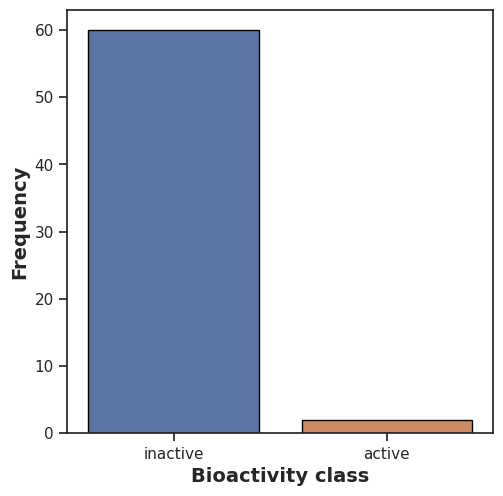

In [71]:
sns.set(style='ticks')
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2classes, edgecolor='black', hue='class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('/content/drive/My Drive/Colab Notebooks/data/plot_bioactivity_class.pdf')

### Gráfica de dispersión

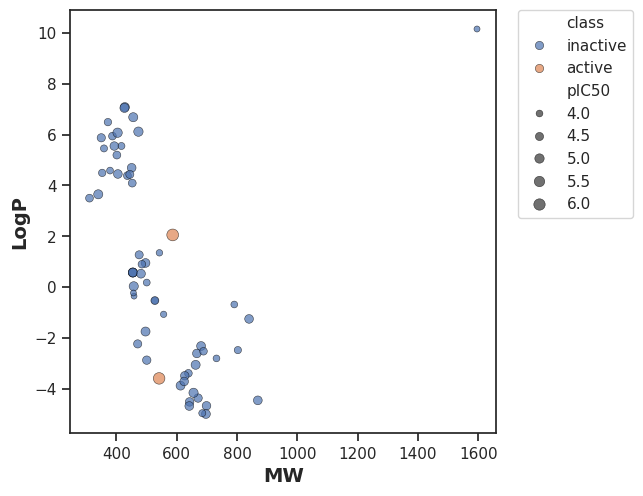

In [73]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2classes, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('/content/drive/My Drive/Colab Notebooks/data/plot_MW_vs_LogP.pdf')

### Diagrama de caja
#### Valor de pIC50

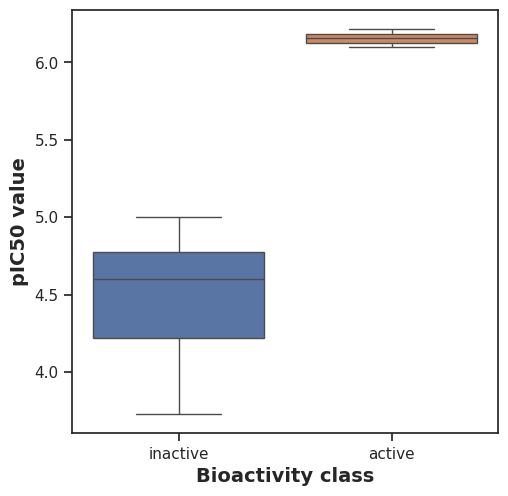

In [77]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2classes, hue = 'class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('/content/drive/My Drive/Colab Notebooks/data/plot_ic50.pdf')

##### Análisis estadístico
**Prueba U Mann-Whitney**


In [78]:
def mannwhitney(descriptor, verbose=False):

  # Generador de semilla aleatoria
    seed(1)

  # Activos e inactivos
    selection = [descriptor, 'class']
    df = df_2classes[selection]
    active = df[df['class'] == 'active']
    active = active[descriptor]

    selection = [descriptor, 'class']
    df = df_2classes[selection]
    inactive = df[df['class'] == 'inactive']
    inactive = inactive[descriptor]

  # Comparar muestras
    stat, p = mannwhitneyu(active, inactive)

  # Interpretar
    alpha = 0.05
    if p > alpha:
      interpretation = 'Same distribution (fail to reject H0)'
    else:
      interpretation = 'Different distribution (reject H0)'

    results = pd.DataFrame({'Descriptor':descriptor,
                            'Statistics':stat,
                            'p':p,
                            'alpha':alpha,
                            'Interpretation':interpretation}, index=[0])
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(f'/content/drive/My Drive/Colab Notebooks/data/{filename}')

    return results

In [79]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,120.0,0.017719,0.05,Different distribution (reject H0)


#### MW

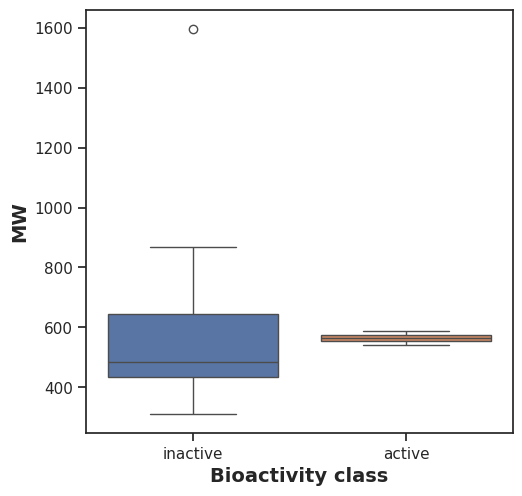

In [81]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2classes, hue = 'class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('/content/drive/My Drive/Colab Notebooks/data/plot_MW.pdf')

In [82]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,76.0,0.536856,0.05,Same distribution (fail to reject H0)


#### LogP

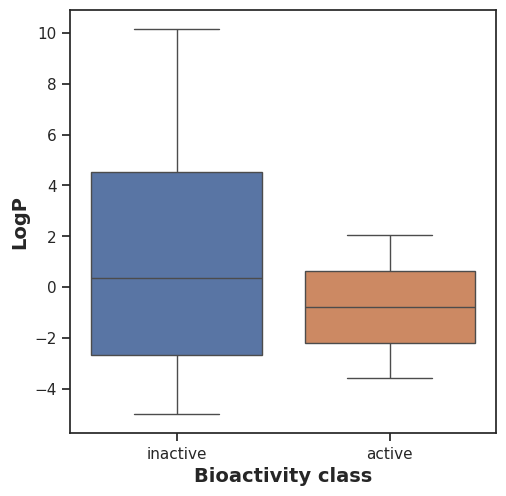

In [84]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2classes, hue = 'class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('/content/drive/My Drive/Colab Notebooks/data/plot_LogP.pdf')

In [85]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,48.0,0.646809,0.05,Same distribution (fail to reject H0)


#### NumHDonors

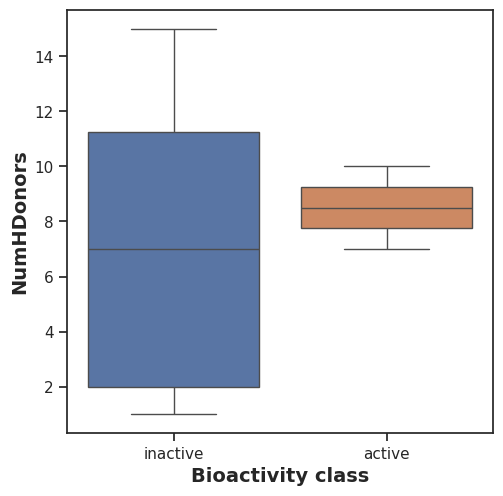

In [87]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2classes, hue = 'class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('/content/drive/My Drive/Colab Notebooks/data/plot_NumHDonors.pdf')

In [88]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,73.0,0.615769,0.05,Same distribution (fail to reject H0)


#### NumHAcceptors

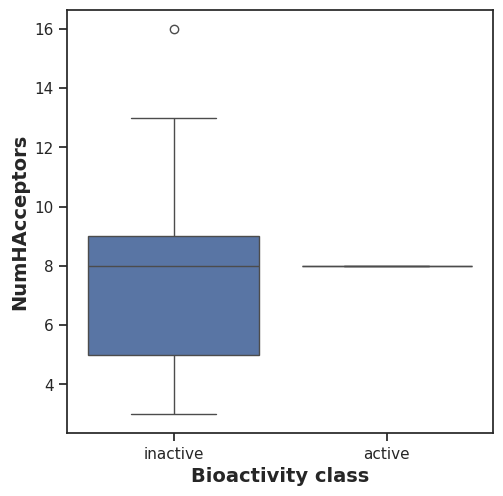

In [92]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2classes)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('/content/drive/My Drive/Colab Notebooks/data/plot_NumHAcceptors.pdf')

In [93]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,63.0,0.91994,0.05,Same distribution (fail to reject H0)


#### Guardar en un archivo comprimido los archivos generados

In [99]:
# Guardar archivos en un archivo zip
!zip -r /content/drive/My\ Drive/Colab\ Notebooks/data/results.zip /content/drive/My\ Drive/Colab\ Notebooks/data/*.pdf /content/drive/My\ Drive/Colab\ Notebooks/data/*.csv

updating: content/drive/My Drive/Colab Notebooks/data/plot_bioactivity_class.pdf (deflated 37%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_ic50.pdf (deflated 38%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_LogP.pdf (deflated 38%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_MW.pdf (deflated 38%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_MW_vs_LogP.pdf (deflated 19%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_NumHAcceptors.pdf (deflated 37%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_NumHDonors.pdf (deflated 37%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50.csv (deflated 77%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data.csv (deflated 90%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data_curated.csv (deflated 83%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data_preprocessed.csv (deflate

In [100]:
# Verificar cambios
! ls '/content/drive/My Drive/Colab Notebooks/data/'

bioactivity_data_2class_pIC50.csv  mannwhitneyu_NumHAcceptors.csv  plot_MW.pdf
bioactivity_data.csv		   mannwhitneyu_NumHDonors.csv	   plot_MW_vs_LogP.pdf
bioactivity_data_curated.csv	   mannwhitneyu_pIC50.csv	   plot_NumHAcceptors.pdf
bioactivity_data_preprocessed.csv  plot_bioactivity_class.pdf	   plot_NumHDonors.pdf
mannwhitneyu_LogP.csv		   plot_ic50.pdf		   results.zip
mannwhitneyu_MW.csv		   plot_LogP.pdf
